### gathering satellite data from gee

In [1]:
!pip install earthengine-api geemap
import ee
ee.Authenticate()
ee.Initialize(project="aurora-482417")  # <-- your project ID

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.4 MB/s eta 0:00:00


In [103]:
import json

def load_geojson(path):
    with open(path) as f:
        return ee.Geometry(json.load(f)["features"][0]["geometry"])

mine_geom = load_geojson("/content/mine_1.geojson")
green_zone_geom = load_geojson("/content/green_zone.geojson")

In [4]:
def mask_s2_clouds(img):
    qa = img.select("QA60")
    cloud  = 1 << 10
    cirrus = 1 << 11
    mask = qa.bitwiseAnd(cloud).eq(0).And(
           qa.bitwiseAnd(cirrus).eq(0))
    return img.updateMask(mask).divide(10000)

In [5]:
def get_monthly_s2(year, month, geom):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, "month")

    col = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(geom)
        .filterDate(start, end)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
        .map(mask_s2_clouds)
    )

    size = col.size()

    def build(img):
        B4  = img.select("B4")
        B8  = img.select("B8")
        B11 = img.select("B11")

        ndvi = B8.subtract(B4).divide(B8.add(B4)).rename("NDVI")
        nbr  = B8.subtract(B11).divide(B8.add(B11)).rename("NBR")

        return ee.Image.cat([ndvi, nbr])

    return ee.Image(
        ee.Algorithms.If(
            size.gt(0),
            build(col.median().clip(geom)),
            None
        )
    )


In [6]:
def get_monthly_s1(year, month, geom):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, "month")

    col = (
        ee.ImageCollection("COPERNICUS/S1_GRD")
        .filterBounds(geom)
        .filterDate(start, end)
        .filter(ee.Filter.eq("instrumentMode", "IW"))
        .filter(ee.Filter.eq("orbitProperties_pass", "DESCENDING"))
        .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))
        .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VH"))
    )

    size = col.size()

    def build(img):
        vv = img.select("VV")
        vh = img.select("VH")
        ratio = vv.subtract(vh).rename("RATIO")
        return ee.Image.cat([vv, vh, ratio])

    return ee.Image(
        ee.Algorithms.If(
            size.gt(0),
            build(col.median().clip(geom)),
            None
        )
    )

In [7]:
def get_valid_months(geom):
    valid = []

    for y in years:
        for m in months:
            s2_count = (
                ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                .filterBounds(geom)
                .filterDate(
                    ee.Date.fromYMD(y, m, 1),
                    ee.Date.fromYMD(y, m, 1).advance(1, "month")
                )
                .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
                .size()
                .getInfo()
            )

            s1_count = (
                ee.ImageCollection("COPERNICUS/S1_GRD")
                .filterBounds(geom)
                .filterDate(
                    ee.Date.fromYMD(y, m, 1),
                    ee.Date.fromYMD(y, m, 1).advance(1, "month")
                )
                .size()
                .getInfo()
            )

            if s2_count > 0 and s1_count > 0:
                valid.append((y, m))

    return valid

In [9]:
years  = range(2020, 2025)
months = [1, 3, 5, 7, 9, 11]
VALID_MONTHS = get_valid_months(mine_geom)
print("Valid months:", VALID_MONTHS)

Valid months: [(2020, 1), (2020, 3), (2020, 5), (2020, 11), (2021, 1), (2021, 3), (2021, 5), (2021, 11), (2022, 1), (2022, 3), (2022, 5), (2022, 11), (2023, 1), (2023, 3), (2023, 5), (2023, 11), (2024, 1), (2024, 3), (2024, 5), (2024, 11)]


### main detection algorithm

In [32]:
import pandas as pd

def run_detection(geom):
    rows = []

    masks_raw = {}   # for metrics / alerts (NO suppression)
    masks_viz = {}   # for frontend visualization (NDVI-suppressed)

    prev_s2 = None
    prev_s1 = None
    prev_change = None
    cum_mask = None

    for y, m in VALID_MONTHS:

        s2 = get_monthly_s2(y, m, geom)
        s1 = get_monthly_s1(y, m, geom)

        if s2 is None or s1 is None:
            continue

        if prev_s2 is None or prev_s1 is None:
            prev_s2, prev_s1 = s2, s1
            continue

        # ---------- CVA ----------
        d_s2 = s2.subtract(prev_s2).pow(2).reduce("sum").sqrt()
        d_s1 = s1.subtract(prev_s1).abs().reduce("sum")

        opt_thresh = (
            d_s2.reduceRegion(
                ee.Reducer.percentile([85]),
                geom, 10, maxPixels=1e13
            ).values().get(0)
        )

        sar_thresh = (
            d_s1.reduceRegion(
                ee.Reducer.percentile([80]),
                geom, 10, maxPixels=1e13
            ).values().get(0)
        )

        opt_mask = d_s2.gt(ee.Image.constant(opt_thresh))
        sar_mask = d_s1.gt(ee.Image.constant(sar_thresh))


        candidate = opt_mask.Or(sar_mask)

        stable = candidate if prev_change is None else candidate.And(prev_change)
        cum_mask = stable if cum_mask is None else cum_mask.Or(stable)

        date_key = f"{y}-{m:02d}-01"

        # ---------- 1️⃣ RAW cumulative mask (NO suppression) ----------
        masks_raw[date_key] = cum_mask.rename("mine_mask")

        # ---------- 2️⃣ VEGETATION-SUPPRESSED mask (ONLY for maps) ----------
        ndvi = s2.select("NDVI")
        veg_free_mask = cum_mask.And(ndvi.lte(0.3))
        masks_viz[date_key] = veg_free_mask.rename("mine_mask_viz")

        cum_mask = cum_mask.rename("mine_mask")

        # ---------- Area computation (STRICTLY raw mask) ----------
        area_img = cum_mask.multiply(ee.Image.pixelArea())

        area = (
            area_img.reduceRegion(
                ee.Reducer.sum(),
                geom, 10, maxPixels=1e13
            ).get("mine_mask")
        )

        rows.append({
            "date": date_key,
            "area_km2": ee.Number(area).divide(1e6).getInfo()
        })

        prev_s2, prev_s1, prev_change = s2, s1, candidate

    return {
        "timeseries": pd.DataFrame(rows),
        "masks_raw": masks_raw,     # metrics / alerts
        "masks_viz": masks_viz      # frontend quantified maps
    }


In [33]:
mine_out  = run_detection(mine_geom)
green_out = run_detection(green_zone_geom)

# ---- time series (metrics, plots, alerts) ----
df_mine   = mine_out["timeseries"]
df_green  = green_out["timeseries"]

# ---- RAW masks (NO suppression → analytics correctness) ----
mine_masks_raw   = mine_out["masks_raw"]
green_masks_raw  = green_out["masks_raw"]

# ---- Visualization masks (NDVI-suppressed → frontend maps) ----
mine_masks_viz   = mine_out["masks_viz"]
green_masks_viz  = green_out["masks_viz"]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df_mine["date"], df_mine["area_km2"], marker="o")
plt.title("Mine Excavated Area (Cumulative)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(df_green["date"], df_green["area_km2"], color="red", marker="o")
plt.title("Green Zone Violation Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [19]:
import json

def first_violation(df):
    v = df[df.area_km2 > 0]
    return v.iloc[0]["date"] if not v.empty else None

outputs = {
    "mine": {
        "current_area_km2": df_mine.area_km2.iloc[-1],
    },
    "green_zone": {
        "first_violation_date": first_violation(df_green),
        "current_area_km2": df_green.area_km2.iloc[-1],
    }
}

df_mine.to_json("timeseries.json", orient="records")
df_green.to_json("green_zone.json", orient="records")

with open("alerts.json", "w") as f:
    json.dump(outputs, f, indent=2)

### quantified maps

[SANITY] 
=== Processing 2020-03 ===
[SANITY] Geometry type: Polygon
[SANITY] Geometry bounds: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[81.40633482999145, 24.377153096993098], [81.40984133955807, 24.377153096993098], [81.40984133955807, 24.38073689518709], [81.40633482999145, 24.38073689518709], [81.40633482999145, 24.377153096993098]]]}
[SANITY] Geometry area (m²): 77098.79826784955
[SANITY] Fetching S2 RGB for 2020-03
[SANITY] S2 collection size: 8
[SANITY] RGB Band B4 shape: (41, 40), max: 0.37459999322891235
[SANITY] RGB Band B3 shape: (41, 40), max: 0.2337000072002411
[SANITY] RGB Band B2 shape: (41, 40), max: 0.18359999358654022
[SANITY] RGB stacked shape: (41, 40, 3), max: 0.37459999322891235
[SANITY] RAW Band mine_mask shape: (41, 40), max: 1
[SANITY] RAW stacked shape: (41, 40, 1), max: 1
[SANITY] Raw mask after threshold shape: (41, 40), sum: 271
[SANITY] NDVI Band NDVI shape: (41, 40), max: 0.630079984664917
[SANITY] NDVI stacked shape: (41, 40, 1), max: 0.63

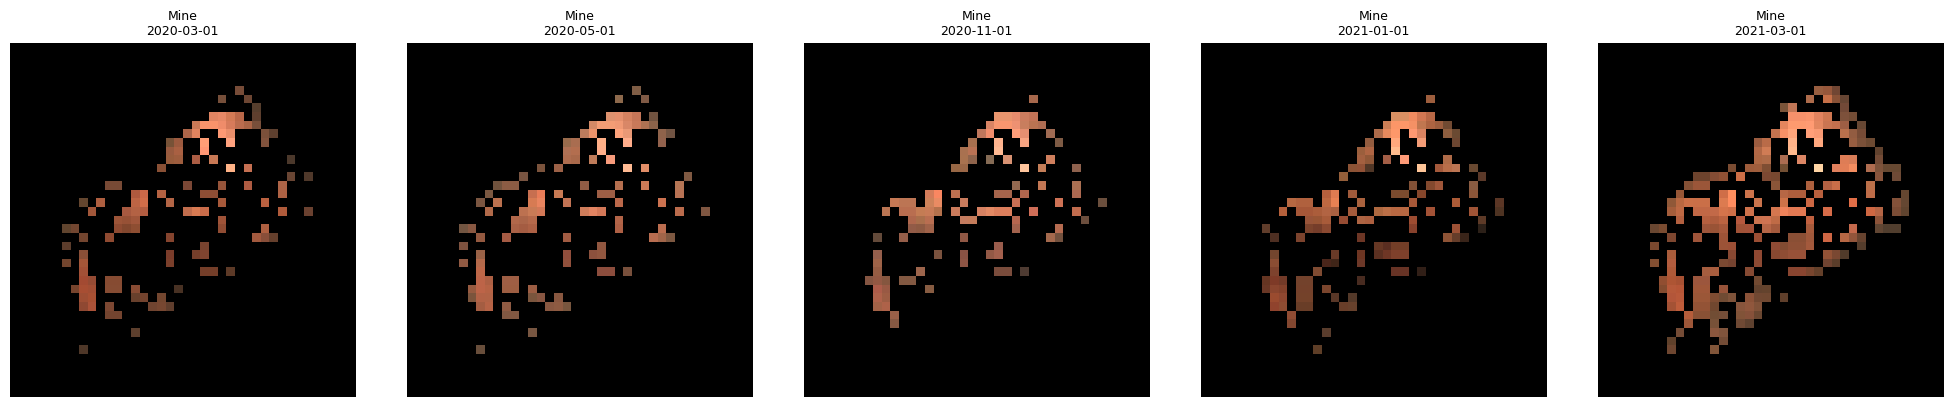

In [114]:
# ============================
# FULL SANITY CHECK VERSION
# ============================

import ee
import numpy as np
import matplotlib.pyplot as plt

SCALE = 10


def log(msg):
    print(f"[SANITY] {msg}")


# ----------------------------
# GEOMETRY CHECK
# ----------------------------
def sanity_check_geom(geom):
    info = geom.getInfo()
    log(f"Geometry type: {info['type']}")
    log(f"Geometry bounds: {geom.bounds().getInfo()}")
    log(f"Geometry area (m²): {geom.area().getInfo()}")


# ----------------------------
# TRUE COLOR FETCH
# ----------------------------
def get_monthly_s2_truecolor(year, month, geom):
    log(f"Fetching S2 RGB for {year}-{month:02d}")

    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, "month")

    col = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(geom)
        .filterDate(start, end)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
        .map(mask_s2_clouds)
    )

    size = col.size().getInfo()
    log(f"S2 collection size: {size}")

    return ee.Image(
        ee.Algorithms.If(
            col.size().gt(0),
            col.median()
               .select(["B4", "B3", "B2"])
               .clip(geom),
            None
        )
    )


# ----------------------------
# EE → NUMPY
# ----------------------------
def ee_img_to_np(img, band_names, geom, tag=""):
    if img is None:
        print(f"[SANITY] {tag} image is None")
        return None

    img = img.reproject(
        crs="EPSG:4326",
        scale=10
    )

    rect = img.sampleRectangle(
        region=geom.bounds(),
        defaultValue=0
    ).getInfo()

    arrays = []
    for b in band_names:
        arr = np.array(rect["properties"][b])
        print(f"[SANITY] {tag} Band {b} shape: {arr.shape}, max: {arr.max()}")
        arrays.append(arr)

    stacked = np.stack(arrays, axis=-1)
    print(f"[SANITY] {tag} stacked shape: {stacked.shape}, max: {stacked.max()}")

    return stacked



# ----------------------------
# QUANTIFIED MAP
# ----------------------------
def quantified_map_from_raw(mask_raw, year, month, geom):

    log(f"\n=== Processing {year}-{month:02d} ===")

    # 0. Geometry sanity
    sanity_check_geom(geom)

    # 1. RGB
    rgb_img = get_monthly_s2_truecolor(year, month, geom)
    rgb = ee_img_to_np(rgb_img, ["B4", "B3", "B2"], geom, tag="RGB")

    if rgb is None:
        log("RGB is None → skipping")
        return None

    # 2. Raw mask
    raw = ee_img_to_np(mask_raw, ["mine_mask"], geom, tag="RAW")
    if raw is None:
        log("Raw mask is None")
        return None

    raw = raw[..., 0] > 0
    log(f"Raw mask after threshold shape: {raw.shape}, sum: {raw.sum()}")

    # 3. NDVI
    s2 = get_monthly_s2(year, month, geom)
    ndvi = ee_img_to_np(s2, ["NDVI"], geom, tag="NDVI")

    if ndvi is None:
        log("NDVI is None")
        return None

    ndvi = ndvi[..., 0]
    log(f"NDVI stats: min={ndvi.min()}, max={ndvi.max()}")

    # 4. Shape reconciliation
    raw  = raw.squeeze()
    ndvi = ndvi.squeeze()

    log(f"Post-squeeze raw shape: {raw.shape}")
    log(f"Post-squeeze ndvi shape: {ndvi.shape}")
    log(f"RGB shape: {rgb.shape}")

    if raw.ndim == 1:
        raw = np.repeat(raw[np.newaxis, :], rgb.shape[0], axis=0)
        log(f"Broadcast raw → {raw.shape}")

    if raw.shape != ndvi.shape:
        log("Broadcasting raw to NDVI shape")
        raw = np.broadcast_to(raw, ndvi.shape)

    # 5. Viz mask
    viz_mask = raw & (ndvi <= 0.3)
    log(f"Viz mask sum: {viz_mask.sum()}")

    rgb[~viz_mask] = 0

    fg = rgb[rgb > 0]
    log(f"Foreground pixel count: {fg.size}")

    if fg.size > 0:
        p = np.percentile(fg, 99)
        log(f"99th percentile RGB: {p}")
        rgb = np.clip(rgb / p, 0, 1)

    log(f"Final RGB shape: {rgb.shape}, max: {rgb.max()}")
    return rgb


# ----------------------------
# PLOTTING
# ----------------------------
def plot_quantified_maps_from_masks(
    masks_viz,
    geom,
    zone="Mine",
    n=5
):
    dates = sorted(masks_viz.keys())[:n]

    fig, axes = plt.subplots(1, len(dates), figsize=(4*len(dates), 4))
    if len(dates) == 1:
        axes = [axes]

    for ax, date in zip(axes, dates):
        y, m = map(int, date.split("-")[:2])

        rgb = quantified_map_from_raw(
            mask_raw=mine_masks_raw[date],
            year=y, month=m,
            geom=geom
        )

        if rgb is None:
            ax.set_title(f"{zone}\n{date}\n(NO DATA)")
            ax.axis("off")
            continue

        ax.imshow(rgb)
        ax.set_title(f"{zone}\n{date}", fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# ----------------------------
# RUN
# ----------------------------
plot_quantified_maps_from_masks(
    mine_masks_raw,
    mine_geom,
    "Mine",
    n=5
)


In [115]:
import json

def save_quantified_maps_json(mine_masks_raw, geom, out_path):
    out = {}

    for date in sorted(mine_masks_raw.keys()):
        y, m = map(int, date.split("-")[:2])

        rgb = quantified_map_from_raw(
            mask_raw=mine_masks_raw[date],
            year=y, month=m,
            geom=geom
        )

        out[date] = {
            "shape": rgb.shape,
            "rgb": rgb.reshape(-1).tolist()
        }

    with open(out_path, "w") as f:
        json.dump(out, f)

    print(f"[OK] Saved maps → {out_path}")


save_quantified_maps_json(
    mine_masks_raw,
    mine_geom,
    "quantified_maps.json"
)


[SANITY] 
=== Processing 2020-03 ===
[SANITY] Geometry type: Polygon
[SANITY] Geometry bounds: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[81.40633482999145, 24.377153096993098], [81.40984133955807, 24.377153096993098], [81.40984133955807, 24.38073689518709], [81.40633482999145, 24.38073689518709], [81.40633482999145, 24.377153096993098]]]}
[SANITY] Geometry area (m²): 77098.79826784955
[SANITY] Fetching S2 RGB for 2020-03
[SANITY] S2 collection size: 8
[SANITY] RGB Band B4 shape: (41, 40), max: 0.37459999322891235
[SANITY] RGB Band B3 shape: (41, 40), max: 0.2337000072002411
[SANITY] RGB Band B2 shape: (41, 40), max: 0.18359999358654022
[SANITY] RGB stacked shape: (41, 40, 3), max: 0.37459999322891235
[SANITY] RAW Band mine_mask shape: (41, 40), max: 1
[SANITY] RAW stacked shape: (41, 40, 1), max: 1
[SANITY] Raw mask after threshold shape: (41, 40), sum: 271
[SANITY] NDVI Band NDVI shape: (41, 40), max: 0.630079984664917
[SANITY] NDVI stacked shape: (41, 40, 1), max: 0.63